# PDF Reporting for Local Reports  
This notebook generates CDTA specific PDF reports.  
- Data from **Flood Net** from local 
- Data for **Flood Watch** from their "API"
- 311 data from Soda API  

Generate visuals with given specs and place them in a folder with named saved to a variable to be placed in the report as image objects separatly.

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import calendar
from datetime import datetime
from fpdf import FPDF
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import geopandas as gpd
import contextily as ctx
import os

blue = '#2093f2'
light_blue = '#39A1FF'

pd.set_option('display.max_columns', None)

report_folder = 'D:\WORK\FLOODNET\Local_Reports'
visual_folder = os.path.join(report_folder, 'Charts')

# Create folder if not exist
if not os.path.exists(visual_folder):
    os.makedirs(visual_folder)

## Load and Prepare Data

### Sensor Data  
Sensor data is in the `Data` folder.  
Simplify data to only used columns

In [2]:
flood_data = pd.read_parquet( os.path.join( report_folder, "Data", 'all_flood_data.parquet'), engine='pyarrow' )
flood_data = flood_data[[ 'time','deployment_id','depth_proc_mm','lat','lon','sensor_display_name' ]]
flood_data = flood_data.dropna( subset=['depth_proc_mm'], axis=0 )

print( flood_data.shape[0] , 'sensor readings' )
flood_data.head(3)

9822685 sensor readings


,time,deployment_id,depth_proc_mm,lat,lon,sensor_display_name
0,2022-10-01 00:00:08.314000+00:00,easily_cosmic_slug,0.0,40.809830,-73.948100,M - 126th St/7th Av
1,2022-10-01 00:00:18.040000+00:00,handsome_violet_leech,0.0,40.695371,-73.794115,Q - 108th Ave/159th St
2,2022-10-01 00:00:19.736000+00:00,daily_happy_satyr,0.0,40.591360,-73.809960,Q - Beach 84 St


### Add CDTA information to Flood Data  
There seems to be projection problem

In [3]:
cdta = gpd.read_file( os.path.join( report_folder, 'Data', "Neighborhood_boundaries_CDTA_NTA_localrpts_3857.geojson" ) )
cdta = cdta.to_crs( 4326 )

cdta = cdta[['CDTAName','labels','geometry']].rename(columns={'labels':'CDTALabel'})
cdta['CDTALabel'] = cdta['CDTALabel'].str.strip()
cdta.head(2)

,CDTAName,CDTALabel,geometry
0,BK03 Bedford-Stuyvesant (CD 3 Approximation),Bedford-Stuyvesant West,"MULTIPOLYGON (((-73.94691 40.67839, -73.94733 ..."
1,BK13 Coney Island-Brighton Beach (CD 13 Approx...,Coney Island-Brighton Beach,"MULTIPOLYGON (((-73.95983 40.57393, -73.96022 ..."


In [4]:
def add_cdta_to_flood_data(df , cdta_boundaries ):

    if 'CDTAName' in df.columns: df = df.drop('CDTAName', axis=1)
    if 'CDTALabel' in df.columns: df = df.drop('CDTALabel', axis=1)

    # extract unique sensors so that we are not matching 1M records
    unique_Sensors = df.groupby('deployment_id').agg({
        'lat':'first',
        'lon':'first'
    })

    # Create a GeoDataFrame from the unique sensors and convert to NY State Plane
    geo_sensors = gpd.GeoDataFrame(unique_Sensors, geometry=gpd.points_from_xy(unique_Sensors.lon, unique_Sensors.lat), crs=4326 )

    # Spatial join the sensors to the CDTA polygons
    geo_sensors = geo_sensors.sjoin(cdta_boundaries[['CDTAName','CDTALabel','geometry']]).drop(['index_right','geometry','lat','lon'], axis=1)

    # Join to the flood data
    return  df.join(geo_sensors, on='deployment_id')

flood_data = add_cdta_to_flood_data( flood_data , cdta )
flood_data.head(3)

,time,deployment_id,depth_proc_mm,lat,lon,sensor_display_name,CDTAName,CDTALabel
0,2022-10-01 00:00:08.314000+00:00,easily_cosmic_slug,0.0,40.809830,-73.948100,M - 126th St/7th Av,MN10 Harlem (CD 10 Equivalent),Harlem
1,2022-10-01 00:00:18.040000+00:00,handsome_violet_leech,0.0,40.695371,-73.794115,Q - 108th Ave/159th St,QN12 Jamaica-St. Albans-Hollis (CD 12 Approxim...,South Jamaica
2,2022-10-01 00:00:19.736000+00:00,daily_happy_satyr,0.0,40.591360,-73.809960,Q - Beach 84 St,QN14 The Rockaways (CD 14 Approximation),Rockaway Beach-Arverne-Edgemere


### Remove Non-Flood Events

In [5]:
events = pd.read_excel( os.path.join(report_folder, 'Data', 'EventsData.xlsx'), sheet_name='All Events till 052023')

def cleanup_events( df ):
    df = df[ df['Deployment_id'] != 'ugliest_cyan_elephant' ] # sensor on the water way 
    df = df[ df['Class'] == 0 ].copy() # 0 is the code for floods

    df['Start_time'] = pd.to_datetime(df['Start_time'])
    df['End_time'] = pd.to_datetime(df['End_time'])

    # drop NaT values and create Intervals
    df = df.dropna(subset=['Start_time','End_time'])
    df['Interval'] =  df.apply( lambda x: pd.Interval(x['Start_time'],x['End_time'],closed='both'),axis=1) 

    df = df.drop(['Borough','Type', 'Deployment_Date','Latitude','Longitude','Address'], axis=1)
    df = df.drop( df.columns[df.columns.str.contains('Unnamed')] ,axis=1) 
    return df

events = cleanup_events(events)
events.head()

,Deployment_id,Start_time,End_time,Duration,Minutes,Class,Interval
0,asleep_apricot_bedbug,2022-09-13 08:25:28,2022-09-13 08:46:44,00:21:16,21.266667,0,"[2022-09-13 08:25:28, 2022-09-13 08:46:44]"
25,big_pink_elephant,2023-03-31 09:49:44,2023-03-31 10:02:27,00:12:43,12.716667,0,"[2023-03-31 09:49:44, 2023-03-31 10:02:27]"
34,big_pink_elephant,2023-04-23 03:19:43,2023-04-23 03:46:06,00:26:23,26.383333,0,"[2023-04-23 03:19:43, 2023-04-23 03:46:06]"
35,big_pink_elephant,2023-04-30 21:24:03,2023-05-01 01:58:11,04:34:08,274.133333,0,"[2023-04-30 21:24:03, 2023-05-01 01:58:11]"
125,blue_eyed_tiger,2023-04-30 21:22:03,2023-04-30 21:36:02,00:13:59,13.983333,0,"[2023-04-30 21:22:03, 2023-04-30 21:36:02]"


In [6]:
def remove_non_flood_events(df_flood, df_events):
   """
   This function assigns 0 to depths that are not during a flood event.
   + converts the depth to inches
   time is in UTC for both dataframes
   Takes a while to run
   """
   
   df_flood['time'] = df_flood['time'].dt.tz_localize(None)
   df_flood['During Flood'] = False
   print( df_events.shape[0] , 'events will be tested' )

   count = 0
   matching_floods = pd.DataFrame()
   for sensor_id in df_flood['deployment_id'].unique():
      t_event = df_events[ (df_events['Deployment_id'] == sensor_id) ]
      t_flood = df_flood[ df_flood['deployment_id'] == sensor_id ].copy()

      for event_interval,sensor_id in zip(t_event['Interval'].values,t_event['Deployment_id'].values ):
         t_flood.loc[ 
            (t_flood['time'].between( event_interval.left, event_interval.right)) & 
            (t_flood['deployment_id'] == sensor_id) , 
            'During Flood'
            ] = True

      matching_floods = pd.concat([matching_floods, t_flood ])

   matching_floods['clean_depth'] = np.where( matching_floods['During Flood'] == True , matching_floods['depth_proc_mm'] , 0 )
   matching_floods['clean_depth_in'] = matching_floods['clean_depth'] / 25.4
   return matching_floods

flood_data = remove_non_flood_events(flood_data, events)
flood_data[ flood_data['During Flood'] == True ].head()


310 events will be tested


,time,deployment_id,depth_proc_mm,lat,lon,sensor_display_name,CDTAName,CDTALabel,During Flood,clean_depth,clean_depth_in
342762,2022-09-19 01:41:29.724,easily_cosmic_slug,0.0,40.80983,-73.9481,M - 126th St/7th Av,MN10 Harlem (CD 10 Equivalent),Harlem,True,0.0,0.000000
342779,2022-09-19 01:42:32.401,easily_cosmic_slug,17.0,40.80983,-73.9481,M - 126th St/7th Av,MN10 Harlem (CD 10 Equivalent),Harlem,True,17.0,0.669291
342791,2022-09-19 01:43:35.263,easily_cosmic_slug,18.0,40.80983,-73.9481,M - 126th St/7th Av,MN10 Harlem (CD 10 Equivalent),Harlem,True,18.0,0.708661
342806,2022-09-19 01:44:38.647,easily_cosmic_slug,17.0,40.80983,-73.9481,M - 126th St/7th Av,MN10 Harlem (CD 10 Equivalent),Harlem,True,17.0,0.669291
342819,2022-09-19 01:45:41.250,easily_cosmic_slug,16.0,40.80983,-73.9481,M - 126th St/7th Av,MN10 Harlem (CD 10 Equivalent),Harlem,True,16.0,0.629921


### Convert Data to NYC time from UTC

In [7]:
# Make filtered data time UTC then convert to America/New_York
flood_data['time_NY'] = flood_data['time'].dt.tz_localize('UTC').dt.tz_convert('America/New_York')
display(flood_data.head(3))

,time,deployment_id,depth_proc_mm,lat,lon,sensor_display_name,CDTAName,CDTALabel,During Flood,clean_depth,clean_depth_in,time_NY
0,2022-10-01 00:00:08.314,easily_cosmic_slug,0.0,40.80983,-73.9481,M - 126th St/7th Av,MN10 Harlem (CD 10 Equivalent),Harlem,False,0.0,0.0,2022-09-30 20:00:08.314000-04:00
16,2022-10-01 00:01:11.458,easily_cosmic_slug,0.0,40.80983,-73.9481,M - 126th St/7th Av,MN10 Harlem (CD 10 Equivalent),Harlem,False,0.0,0.0,2022-09-30 20:01:11.458000-04:00
38,2022-10-01 00:02:13.998,easily_cosmic_slug,0.0,40.80983,-73.9481,M - 126th St/7th Av,MN10 Harlem (CD 10 Equivalent),Harlem,False,0.0,0.0,2022-09-30 20:02:13.998000-04:00


## PLOTS  
All plots will be generated here and will be saved in a PNG file in the `Charts` folder.

In [8]:
[i for i in flood_data['CDTALabel'].unique()]

['Harlem',
 'South Jamaica',
 'Rockaway Beach-Arverne-Edgemere',
 'Morningside Heights-Hamilton Heights',
 'Westerleigh-Castleton Corners',
 'Park Slope-Carroll Gardens',
 'Morrisania-Crotona Park East',
 'Howard Beach-Lindenwood',
 'Soundview',
 'New Springville-Willowbrook-Bulls Head-Travis',
 'Bedford-Stuyvesant West',
 'Greenwich Village-SoHo',
 'Williamsburg-Greenpoint',
 'North Shore',
 'Mid-Island']

In [9]:
cd_name = 'Park Slope-Carroll Gardens'

In [10]:
local_data = flood_data[ flood_data['CDTALabel'] == cd_name ].copy()
local_data.head(3)

,time,deployment_id,depth_proc_mm,lat,lon,sensor_display_name,CDTAName,CDTALabel,During Flood,clean_depth,clean_depth_in,time_NY
5,2022-10-01 00:00:37.191,jolly_tender_squid,0.0,40.675734,-74.003396,BK - Henry St/Mill St,BK06 Park Slope-Carroll Gardens (CD 6 Approxim...,Park Slope-Carroll Gardens,False,0.0,0.0,2022-09-30 20:00:37.191000-04:00
28,2022-10-01 00:01:40.368,jolly_tender_squid,0.0,40.675734,-74.003396,BK - Henry St/Mill St,BK06 Park Slope-Carroll Gardens (CD 6 Approxim...,Park Slope-Carroll Gardens,False,0.0,0.0,2022-09-30 20:01:40.368000-04:00
47,2022-10-01 00:02:43.190,jolly_tender_squid,0.0,40.675734,-74.003396,BK - Henry St/Mill St,BK06 Park Slope-Carroll Gardens (CD 6 Approxim...,Park Slope-Carroll Gardens,False,0.0,0.0,2022-09-30 20:02:43.190000-04:00


### PLOT 1: 
Flood sensor locations + frequency of days with floods

In [11]:
# Get max depth for each deployment per day
daily_max_flood = local_data.groupby( ['deployment_id', pd.Grouper(key='time_NY', freq='1d')] ).agg({'clean_depth_in':'max' }).reset_index()
# Filter out days with no flooding
daily_max_flood = daily_max_flood[ daily_max_flood['clean_depth_in'] > 0.0 ]

#Count Flooded Days
flooded_days = daily_max_flood.groupby('deployment_id').size().reset_index().rename(columns={0:'flooded_days'})

# First date sensor recorded data, this will be the annotation
first_record = local_data.groupby('deployment_id').agg({'time_NY':'min','sensor_display_name':'first'})
first_record['sensor_display_name'] = first_record['sensor_display_name'].str.split(' - ' ).str[1].str.strip()
# Join Data
flooded_days_map = local_data.groupby('deployment_id').agg({'lat':'first','lon':'first'}).join( flooded_days.set_index('deployment_id') ).join( first_record )
flooded_days_map['time_NY'] = flooded_days_map['time_NY'].dt.strftime('%Y-%m-%d')

# GeoDataFrame
flooded_days_map = gpd.GeoDataFrame(flooded_days_map, geometry=gpd.points_from_xy(flooded_days_map.lon, flooded_days_map.lat), crs=4326).to_crs(3857)
flooded_days_map.head()

,lat,lon,flooded_days,time_NY,sensor_display_name,geometry
deployment_id,,,,,,
daily_gentle_beetle,40.675855,-73.983944,NaN,2021-10-07,4th Av/Garfield Pl,POINT (-8235854.941 4964647.246)
daily_new_falcon,40.676672,-73.994591,10.0,2020-10-05,Hoyt St/5th St,POINT (-8237040.186 4964767.202)
early_still_frog,40.673707,-74.004350,2.0,2022-02-18,Lorraine St/Henry St,POINT (-8238126.503 4964331.941)
evenly_divine_dingo,40.674602,-74.016070,NaN,2022-02-18,Van Brunt St/Reed St,POINT (-8239431.201 4964463.409)
gladly_mint_snail,40.679734,-74.012422,NaN,2022-02-18,Pioneer St/Conover St,POINT (-8239025.138 4965216.588)


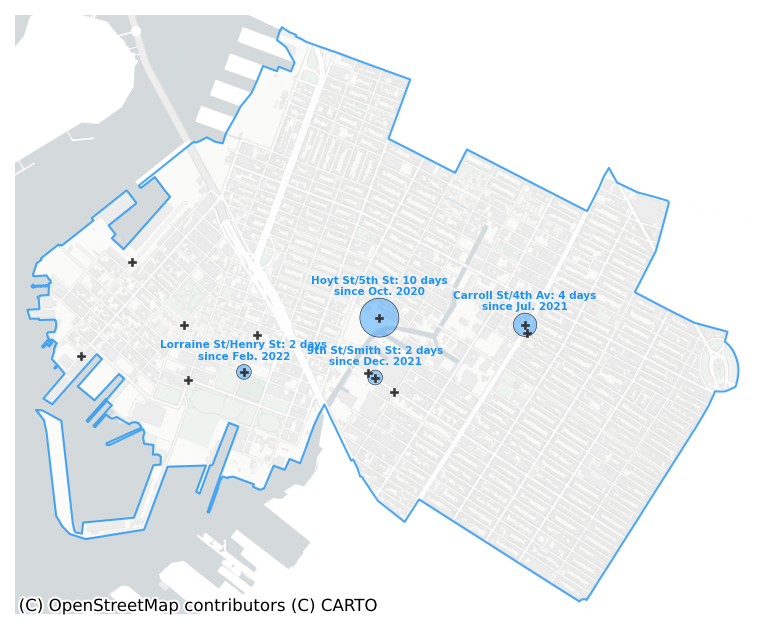

In [12]:
local_cdta = cdta[cdta['CDTALabel'] == cd_name ].to_crs(3857)
other_cdta = cdta[cdta['CDTALabel'] != cd_name ].to_crs(3857)

fig,ax = plt.subplots(figsize=(5,4), dpi=150)
local_cdta.plot( ax=ax , fc = 'none' , ec = blue, alpha = 0.8 , zorder = 10 )
other_cdta.plot( ax=ax , fc = 'white' , ec = 'none', alpha = 1 )

# Define plot bounds by local cdta + padding
pad = 100
ax.set_xlim( local_cdta['geometry'].bounds.minx.values[0]-pad , local_cdta['geometry'].bounds.maxx.values[0]+pad )
ax.set_ylim( local_cdta['geometry'].bounds.miny.values[0]-pad , local_cdta['geometry'].bounds.maxy.values[0]+pad )

# Sensors with Flooding
with_flooding = flooded_days_map[ flooded_days_map['flooded_days'].notnull() ]

sns.scatterplot(
    x = with_flooding.geometry.x,
    y = with_flooding.geometry.y,
    ax = ax,
    facecolor = light_blue,
    edgecolor = 'none',
    size = with_flooding[ 'flooded_days' ],
    sizes = ( 50 , 350 ),
    alpha = 0.5,
)

sns.scatterplot(
    x = with_flooding.geometry.x,
    y = with_flooding.geometry.y,
    ax = ax,
    facecolor = 'none',
    edgecolor = "#333333",
    size = with_flooding[ 'flooded_days' ],
    sizes = ( 50 , 350 ),
    linewidth = 0.3
)

# All Sensors shown as +
sns.scatterplot(
    x = flooded_days_map.geometry.x,
    y = flooded_days_map.geometry.y,
    ax = ax,
    marker = 'P',
    facecolor = "#333",
    edgecolor =  None,
    s = 12 
    )

# Annotations
with_flooding.apply(
    lambda x: ax.annotate( 
        text = f"{x['sensor_display_name']}: {int(x['flooded_days']) } days\nsince {pd.to_datetime(x['time_NY']).strftime('%b. %Y')}", 
        xy = ( x.geometry.x , x.geometry.y ) , 
        xytext = ( 0 , np.interp( x['flooded_days'], [with_flooding['flooded_days'].min(), with_flooding['flooded_days'].max()], [5, 10]) ) , 
        textcoords = 'offset points' , ha = 'center' , va = 'bottom' , fontsize = 5, fontweight='bold' , color = blue ),
    axis = 1
)

ctx.add_basemap( ax, source=ctx.providers.CartoDB.PositronNoLabels )

ax.axis('off')
ax.legend([], frameon=False)

plt.tight_layout(pad=0)
map1_path = os.path.join( visual_folder , "map1.png" )
plt.savefig( map1_path , dpi = 150, bbox_inches='tight' ,transparent="True", pad_inches=0)

### Inset Map, of NYC

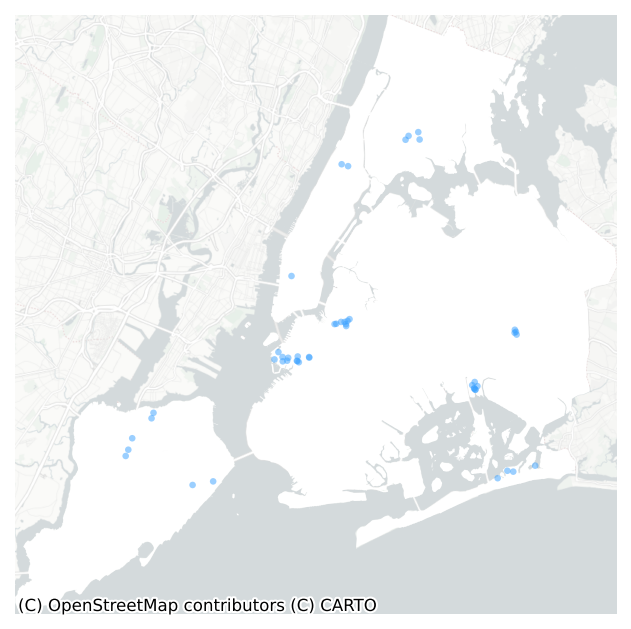

In [13]:
fig,ax = plt.subplots(figsize=(5,4), dpi=150)

projected_cdta = cdta.dissolve().to_crs(3857)
projected_cdta.plot( ax=ax , fc = 'white' , ec = 'none', alpha = 1 )

sensor_locations = flood_data.groupby('deployment_id').agg({
        'lat':'first',
        'lon':'first'
    }).reset_index()

sensor_locations = gpd.GeoDataFrame( sensor_locations, geometry=gpd.points_from_xy(sensor_locations.lon, sensor_locations.lat), crs=4326 ).to_crs(3857) 
sensor_locations.plot( ax=ax , fc = light_blue , ec = 'none', alpha = 0.5 , markersize = 10)

ctx.add_basemap( ax, source=ctx.providers.CartoDB.PositronNoLabels )
ax.axis('off')

# Define plot bounds by local cdta + padding
pad = 10
ax.set_xlim( projected_cdta['geometry'].bounds.minx.values[0]-pad , projected_cdta['geometry'].bounds.maxx.values[0]+pad )
ax.set_ylim( projected_cdta['geometry'].bounds.miny.values[0]-pad , projected_cdta['geometry'].bounds.maxy.values[0]+pad )

plt.tight_layout(pad=0)
insetmap_path = os.path.join( visual_folder , "insetmap.png" )
plt.savefig( insetmap_path , dpi = 150, bbox_inches='tight' ,transparent="True", pad_inches=0)

### 311 Complaints Heat Map

In [14]:

import requests

data_query = 'https://data.cityofnewyork.us/resource/erm2-nwe9.json'
# Add more descriptors here
# descriptors = ['Street Flooding (SJ)','Catch Basin Clogged/Flooding (Use Comments) (SC)','Sewer Backup (Use Comments) (SA)','Failure To Retain Water/Improper Drainage- (LL103/89)','Manhole Overflow (Use Comments) (SA1)','Snow/Ice']

descriptors = ['Street Flooding (SJ)','Catch Basin Clogged/Flooding (Use Comments) (SC)', 'Manhole Overflow (Use Comments) (SA1)' ]

descriptors_filter = ' OR '.join([f"descriptor='{d}'" for d in descriptors])
selectors = 'unique_key,created_date,agency,complaint_type,descriptor,status,latitude,longitude'

start_date = ( pd.Timestamp.today() - pd.Timedelta(days=360*3))
# start_date to the beginning of the year
start_date = start_date.replace(month=1,day=1).date().strftime('%Y-%m-%d')

polygon = local_cdta \
                .dissolve() \
                .to_crs(4326) \
                .geometry.values[0]

url = f"{data_query}?$where=within_polygon(location, '{polygon}') AND created_date>'{start_date}' AND ({descriptors_filter})&$select={selectors}&$limit=5000"
print( url )
response = requests.get(url)
if response.status_code != 200:
    print(f"Error {response.status_code}")
else:
    data_311 = pd.DataFrame( response.json() )
data_311

https://data.cityofnewyork.us/resource/erm2-nwe9.json?$where=within_polygon(location, 'POLYGON ((-73.9737607775333 40.68304894658965, -73.97375287413374 40.68298894973064, -73.97372614948627 40.68293364684841, -73.97393492082199 40.68233005992501, -73.97395594672192 40.68226927207195, -73.97422664485593 40.68150418104919, -73.97439137364128 40.68104571286033, -73.97450389095998 40.68073274719293, -73.97469111656514 40.68026616132372, -73.97490467111457 40.6799536769359, -73.97495731331641 40.67987665823493, -73.9753218604144 40.67933232322022, -73.97574922969018 40.67869925542473, -73.97618044868182 40.6780638724106, -73.97368689938453 40.67707755118825, -73.97188591456026 40.6763942006085, -73.96949733979974 40.67590592463797, -73.96969312764293 40.67536040040671, -73.9695827357873 40.67529619829784, -73.96947823673469 40.67522651380005, -73.96938009930228 40.6751516595536, -73.9692887637613 40.67507197139178, -73.96920463972357 40.67498780719041, -73.9691281046875 40.67489954418649, 

,unique_key,created_date,agency,complaint_type,descriptor,status,latitude,longitude
0,58444902,2023-08-08T14:26:00.000,DEP,Sewer,Street Flooding (SJ),Closed,40.68132335048843,-74.00893067976263
1,58452672,2023-08-08T14:23:00.000,DEP,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),Closed,40.68132335048843,-74.00893067976263
2,58379480,2023-08-01T16:41:00.000,DEP,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),Closed,40.67606745545129,-73.99985579368702
3,58361134,2023-07-30T19:59:00.000,DEP,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),Closed,40.682824904196806,-74.00649715272053
4,58347414,2023-07-29T14:02:00.000,DEP,Sewer,Street Flooding (SJ),Closed,40.679890436988295,-73.98939662299307
...,...,...,...,...,...,...,...,...
517,45473842,2020-01-25T18:14:00.000,DEP,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),Closed,40.6724140389682,-73.99472594301481
518,45431754,2020-01-20T12:58:00.000,DEP,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),Closed,40.68214859644519,-73.98285591118919
519,45422876,2020-01-18T12:14:00.000,DEP,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),Closed,40.67844164011407,-73.99678047944896
520,45327150,2020-01-06T09:06:00.000,DEP,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),Closed,40.66906054648242,-73.97728989146187


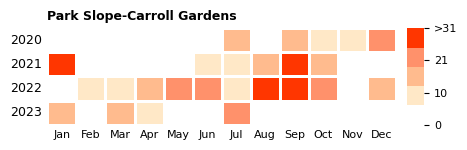

In [15]:
data_311['created_date'] = pd.to_datetime(data_311['created_date'])
data_311['year'] = data_311['created_date'].dt.year
data_311['month'] = data_311['created_date'].dt.month

def make_Ramp( ramp_colors ): 
    from colour import Color
    # from matplotlib.colors import LinearSegmentedColormap
    from matplotlib.colors import ListedColormap, LinearSegmentedColormap

    color_ramp = ListedColormap( ramp_colors )
    return color_ramp

values = ['#ffffff','#ffe8c7','#ffbb8e','#ff916b','#ff3600']
custom_ramp = make_Ramp( values ) 

pt_yearcomp = pd.pivot_table(
    data_311,
    index='year',
    columns='month',
    values='unique_key',
    aggfunc="nunique",
)

highest_value = np.quantile( np.ravel(pt_yearcomp.fillna(0)) , 0.95 )

fig,ax = plt.subplots(figsize=(4.9,1.6))
sns.heatmap(
    pt_yearcomp,
    linewidths=1,
    linecolor='white',
    cmap = custom_ramp,
    vmin = 0,
    ax=ax,
    cbar = True,
    vmax = highest_value,
    cbar_kws={'aspect':5.5, 'pad':0.025 }
)

colorbar = ax.collections[0].colorbar
# Format Heatmap Ticks
n = 3
r = colorbar.vmax - colorbar.vmin 
ticks = [(colorbar.vmin + r / n) * (i) for i in range(n+1)]
colorbar = ax.collections[0].colorbar 
colorbar.set_ticks( ticks )
colorbar.set_ticklabels( [ str(int(tick)) if tick != max(ticks) else f">{int(tick)}" for tick in ticks] )
colorbar.ax.tick_params(labelsize=8)  

plt.xlabel('')
plt.ylabel('')

plt.tick_params( axis='both', which='both', bottom=False, top=False, left=False, right=False , labelsize=9, pad=0.35 )

# convert x-tick labels into month names
month_names = [ 'Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec' ]
ax.set_xticklabels( month_names, rotation=0, fontsize=8 )
ax.set_title( cd_name, fontsize=9, pad=6, loc='left', fontweight='bold')

plt.tight_layout()

heatmap_path = os.path.join( visual_folder, f"{cd_name}_heatmap.png" )
plt.savefig( heatmap_path, dpi=150, bbox_inches='tight', transparent="True", pad_inches=0 );

### Get Photos From MyCoast

In [ ]:
# myCoast API

url = 'https://mycoast.org/wp-admin/admin-ajax.php?action=mapp_query&debug=&filters=&otype=post&query[post_type]=post&query[category_name]=highwater&query[tag__and][]=121&url[href]=https://mycoast.org/ny/flood-watch&url[search]='

headers = { 'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/116.0'}

response = requests.get(url, headers=headers)
response.content
data = response.json()
data = data['data']

data


{'timing': None,
 'wpq': "\n\t\t\tSELECT   wp_posts.ID, wp_posts.post_name, wp_posts.post_date, wp_posts.post_type, wp_mapp_maps.obj\n\t\t\tFROM wp_posts  LEFT JOIN wp_term_relationships ON (wp_posts.ID = wp_term_relationships.object_id) INNER JOIN wp_mapp_maps ON (wp_mapp_maps.oid = wp_posts.ID AND wp_mapp_maps.otype = 'post' AND wp_mapp_maps.status != 'trashed') \n\t\t\tWHERE 1=1  AND ( \n  wp_term_relationships.term_taxonomy_id IN (207) \n  AND \n  (\n\t\t\t\tSELECT COUNT(1)\n\t\t\t\tFROM wp_term_relationships\n\t\t\t\tWHERE term_taxonomy_id IN (127,220)\n\t\t\t\tAND object_id = wp_posts.ID\n\t\t\t) = 2\n) AND ((wp_posts.post_type = 'post' AND (wp_posts.post_status = 'publish' OR wp_posts.post_status = 'closed' OR wp_posts.post_status = 'acf-disabled')))\n\t\t\tGROUP BY wp_posts.ID, wp_mapp_maps.mapid\n\t\t\tORDER BY wp_posts.post_date DESC\n\t\t\t\n\t\t",
 'pois': [{'address': '43.1484885291, -76.3268923077',
   'body': '',
   'data': None,
   'email': None,
   'iconid': 'highwater

In [ ]:
fw = pd.DataFrame.from_dict( data['pois'] )
fw = fw[['oid','point','props','url']]

# fw['locality'] = fw['props'].apply( lambda x: x['geo_locality'] )
# fw['admin_area'] = fw['props'].apply( lambda x: x['geo_administrative_area_level_1'] )
fw['photo_date'] = fw['props'].apply( lambda x: x['photo_date'] )
fw['photo_time'] = fw['props'].apply( lambda x: x['photo_time'] )

fw['photos'] = fw['props'].apply(lambda x: [i.split("src='")[1].split("'")[0].replace('-100x75','') for i in x['ourPics'].split("<a href=")[1:]] )

fw['lat'] = fw['point'].apply( lambda x: x['lat'] )
fw['lng'] = fw['point'].apply( lambda x: x['lng'] )

fw['datetime'] = pd.to_datetime( fw['photo_date'] + ' ' + fw['photo_time'] )

gfw = gpd.GeoDataFrame( fw.drop(['point'],axis=1), geometry=gpd.points_from_xy( fw.lng, fw.lat ), crs = 4326 )
gfw.head()

,oid,props,url,photo_date,photo_time,photos,lat,lng,datetime,geometry
0,123348,"{'geo_locality': 'Baldwinsville', 'geo_adminis...",https://mycoast.org/reports/123348,2023-08-08,8:12 am,[https://report-images.nyc3.digitaloceanspaces...,43.1484885291,-76.3268923077,2023-08-08 08:12:00,POINT (-76.32689 43.14849)
1,123345,"{'geo_locality': 'Baldwinsville', 'geo_adminis...",https://mycoast.org/reports/123345,2023-08-07,9:27 pm,[https://report-images.nyc3.digitaloceanspaces...,43.1321194362,-76.3058289468,2023-08-07 21:27:00,POINT (-76.30583 43.13212)
2,122063,"{'geo_locality': '', 'geo_administrative_area_...",https://mycoast.org/reports/122063,2023-07-18,07:49 pm,[https://report-images.nyc3.digitaloceanspaces...,42.6819404676,-73.8400766737,2023-07-18 19:49:00,POINT (-73.84008 42.68194)
3,121936,"{'geo_locality': 'New Paltz', 'geo_administrat...",https://mycoast.org/reports/121936,2023-07-16,2:46 pm,[https://report-images.nyc3.digitaloceanspaces...,41.7432283333,-74.0931555,2023-07-16 14:46:00,POINT (-74.09316 41.74323)
4,121933,"{'geo_locality': 'New Paltz', 'geo_administrat...",https://mycoast.org/reports/121933,2023-07-16,2:31 pm,[https://report-images.nyc3.digitaloceanspaces...,41.7612083333,-74.0858221667,2023-07-16 14:31:00,POINT (-74.08582 41.76121)


In [81]:
import imageio
import lxml.html

buffered_local = local_cdta.copy()
buffered_local = buffered_local.dissolve()
buffered_local = buffered_local.to_crs(2263)
buffered_local['geometry'] = buffered_local.buffer( 7920 ) # this is 1.5 miles
buffered_local = buffered_local.to_crs(4326)

joined_gfw = gfw.sjoin( buffered_local )

local_gfw = joined_gfw[ joined_gfw['CDTALabel'] == cd_name ].copy()

# ------- Comments
def get_comments( url ):
    request = requests.get( url , headers = headers )
    html = lxml.html.fromstring( request.content )
    comments = []
    for i in html.xpath( '//div[@class="post-author-comment"]/h6' ):
        comments.append( i.text_content() )
    return comments

local_gfw['author_comment'] = local_gfw['url'].apply( lambda x: get_comments( x ) )
local_gfw

,oid,props,url,photo_date,photo_time,photos,lat,lng,datetime,geometry,index_right,CDTAName,CDTALabel,author_comment
14,115938,"{'geo_locality': '', 'geo_administrative_area_...",https://mycoast.org/reports/115938,2023-05-01,08:59 am,[https://report-images.nyc3.digitaloceanspaces...,40.6493612,-74.0095916,2023-05-01 08:59:00,POINT (-74.00959 40.64936),0,BK06 Park Slope-Carroll Gardens (CD 6 Approxim...,Park Slope-Carroll Gardens,"[""It's not even raining today. The rain water ..."
141,96474,"{'geo_locality': '', 'geo_administrative_area_...",https://mycoast.org/reports/96474,2022-11-11,07:05 pm,[https://report-images.nyc3.digitaloceanspaces...,40.67786845164485,-73.94411962228337,2022-11-11 19:05:00,POINT (-73.94412 40.67787),0,BK06 Park Slope-Carroll Gardens (CD 6 Approxim...,Park Slope-Carroll Gardens,"[""Flash flooding at intersection of Brooklyn A..."
168,113708,"{'geo_locality': '', 'geo_administrative_area_...",https://mycoast.org/reports/113708,2012-10-22,7:30 pm,[https://report-images.nyc3.digitaloceanspaces...,40.6759445259,-74.0086725961,2012-10-22 19:30:00,POINT (-74.00867 40.67594),0,BK06 Park Slope-Carroll Gardens (CD 6 Approxim...,Park Slope-Carroll Gardens,"[""I’m not sure of the date or time. I do know ..."


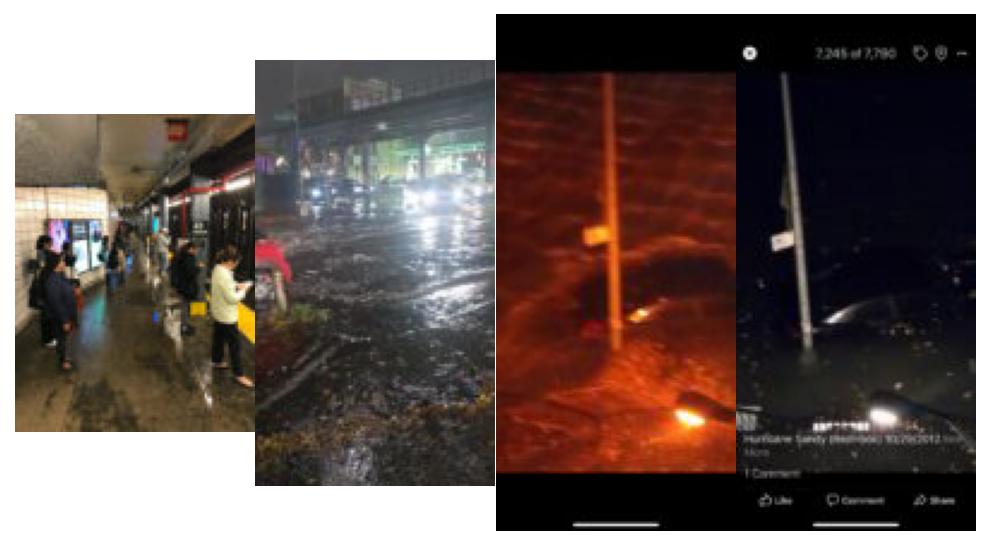

In [87]:
# ------- Photos
photos = local_gfw['photos'].values
photos = [ photo for sublist in photos for photo in sublist ]

if len(photos) > 1:
    fig,axs = plt.subplots( ncols = len(photos), dpi=150 )

    for i, photo in enumerate(photos):
        img = imageio.v2.imread( photo )
        axs[i].imshow( img )
        axs[i].set_axis_off()
        axs[i].set_aspect('equal')

plt.subplots_adjust(wspace=0.05, hspace=0)
plt.tight_layout( pad=0.0, w_pad=0.05, h_pad=0.0 )

flood_photos_path = os.path.join( visual_folder, 'flood_photos.png' )
plt.savefig( flood_photos_path , bbox_inches='tight', pad_inches=0.0, dpi=150 )